In [2]:
%pip install tensorflow
%pip install keras

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Using cached grpcio-1.73.1-cp311-cp311-win_amd64.whl (4.3 MB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-win_amd64.whl (105 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl (157 kB)
  Using cached markdown-3.8.2-py3-none-any.whl (106 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: keras in c:\users\users\appdata\local\programs\python\python311\lib\site-packages (3.10.0)




[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
#traer libreria de keras para guardar y cargar redes neuronales
from keras.models import load_model


In [95]:
# 📦 Imports y carga de datos
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
import numpy as np
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Cargar dataset
df = pd.read_csv("../dataset/F1_Datos_limpios.csv", encoding='utf-8', low_memory=False)

In [96]:
df.head()

,raceId,year,round,circuitId,name_x,date,time_x,circuitRef,name_y,location,...,avg_grid,wins,dnfs,dnf_rate,win_rate,temperature_C,precipitation_mm,wind_speed_kmh,humidity_pct,isRainy
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,...,10.006472,15,67,0.216828,0.048544,20.74,0.0,20.74,54.0,False
1,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,...,8.910769,11,96,0.295385,0.033846,20.74,0.0,20.74,54.0,False
2,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,...,10.402344,1,86,0.335938,0.003906,20.74,0.0,20.74,54.0,False
3,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,...,17.180851,0,20,0.212766,0.000000,20.74,0.0,20.74,54.0,False
4,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,...,8.600496,32,69,0.171216,0.079404,20.74,0.0,20.74,54.0,False


In [97]:
df.sort_values(by='raceId', inplace=True)

In [98]:
# 🎯 Selección de features y target
features = [
    'grid','avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position',
    'races', 'wins', 'dnfs','win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races',
    'circuit_prev_dnfs','circuit_prev_wins','circuit_prev_avg_pos','circuit_prev_avg_points','circuit_prev_dnf_rate','circuit_prev_win_rate',
    'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change',
    'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'driver_age', 'race_year', 'race_month', 'race_day', 'race_hour'
]
target = 'DNF'

# Filtrado y limpieza
df_original = df.copy()
df = df[features + [target]].dropna()
X = df[features]
y = df[target]


,grid,avg_grid,avg_position_change,avg_real_points,avg_position,races,wins,dnfs,win_rate,dnf_rate,...,precipitation_mm,wind_speed_kmh,humidity_pct,isRainy,driver_age,race_year,race_month,race_day,race_hour,DNF
339,1,4.312676,-0.695775,14.515493,3.627692,355,105,30,0.295775,0.084507,...,0.0,22.750000,15.500000,False,23.0,2008.0,3.0,16.0,4.0,0
340,5,11.336957,0.614130,3.951087,8.355072,184,0,46,0.000000,0.250000,...,0.0,22.750000,15.500000,False,30.0,2008.0,3.0,16.0,4.0,0
341,7,6.902913,-1.349515,8.441748,6.355932,206,23,29,0.111650,0.140777,...,0.0,22.750000,15.500000,False,22.0,2008.0,3.0,16.0,4.0,0
342,11,8.600496,0.126551,7.861042,6.464072,403,32,69,0.079404,0.171216,...,0.0,22.750000,15.500000,False,26.0,2008.0,3.0,16.0,4.0,0
343,3,13.741071,0.455357,2.526786,11.835165,112,1,21,0.008929,0.187500,...,0.0,22.750000,15.500000,False,26.0,2008.0,3.0,16.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25113,15,15.707692,1.030769,0.246154,13.945455,65,0,10,0.000000,0.153846,...,0.0,17.971429,39.571429,False,25.0,2024.0,12.0,8.0,13.0,0
25114,13,13.475610,1.134146,1.701220,11.292857,164,0,24,0.000000,0.146341,...,0.0,17.971429,39.571429,False,26.0,2024.0,12.0,8.0,13.0,0
25116,14,13.361111,-0.144444,1.083333,12.476510,180,0,31,0.000000,0.172222,...,0.0,17.971429,39.571429,False,32.0,2024.0,12.0,8.0,13.0,0
25118,9,7.991770,-0.905350,7.267490,7.778802,243,10,26,0.041152,0.106996,...,0.0,17.971429,39.571429,False,35.0,2024.0,12.0,8.0,13.0,1


In [99]:
# 🧠 Codificación y balanceo con SMOTE
X = pd.get_dummies(X, drop_first=True)

# Balanceo de clases
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [8]:
X_train

,grid,avg_grid,avg_position_change,avg_real_points,avg_position,races,wins,dnfs,win_rate,dnf_rate,...,humidity_pct,driver_age,race_year,race_month,race_day,race_hour,circuit_type_other,circuit_type_permanent,circuit_type_street,isRainy_True
4816,7,8.665049,-0.572816,5.820388,7.213018,206,4,37,0.019417,0.179612,...,73.714286,29.000000,2024.000000,4.000000,21.000000,7.000000,False,True,False,False
6818,17,13.741071,0.455357,2.526786,11.835165,112,1,21,0.008929,0.187500,...,64.857043,29.528707,2011.528707,3.235647,14.700947,6.471293,False,True,False,False
6097,13,10.006472,0.310680,5.990291,7.409091,309,15,67,0.048544,0.216828,...,61.915779,35.772921,2015.772921,6.227079,10.410450,16.637529,False,True,False,False
6539,7,8.665049,-0.572816,5.820388,7.213018,206,4,37,0.019417,0.179612,...,55.213501,24.841533,2018.920767,8.841533,8.000000,13.000000,False,True,False,False
1332,5,8.600496,0.126551,7.861042,6.464072,403,32,69,0.079404,0.171216,...,56.428571,30.000000,2011.000000,11.000000,13.000000,13.000000,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,16,16.283019,1.009434,1.207547,12.339286,106,0,50,0.000000,0.471698,...,69.367190,40.164666,2011.164666,4.582333,17.393659,10.329332,False,True,True,True
3521,5,4.980769,-0.605769,13.927885,3.547486,208,63,29,0.302885,0.139423,...,60.333333,22.000000,2019.000000,10.000000,13.000000,5.000000,False,True,False,False
6531,10,10.676991,-1.199115,2.455752,10.125000,226,0,42,0.000000,0.185841,...,77.369687,29.367238,2016.822984,8.088508,23.645968,12.455746,False,True,True,True
588,4,8.600496,0.126551,7.861042,6.464072,403,32,69,0.079404,0.171216,...,53.857143,25.000000,2006.000000,10.000000,22.000000,14.000000,False,True,False,False


In [100]:
import tensorflow as tf


# Verificar si hay GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para usar memoria dinámica en la GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU habilitada para el entrenamiento.")
    except RuntimeError as e:
        print(f"❌ Error al habilitar la GPU: {e}")
else:
    print("⚠️ No se encontraron GPUs disponibles. El entrenamiento se realizará en la CPU.")

⚠️ No se encontraron GPUs disponibles. El entrenamiento se realizará en la CPU.


NameError: name 'X_train' is not defined

In [101]:
#ZeroR para comparación
from sklearn.dummy import DummyClassifier
zeroR = DummyClassifier(strategy='most_frequent')
zeroR.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

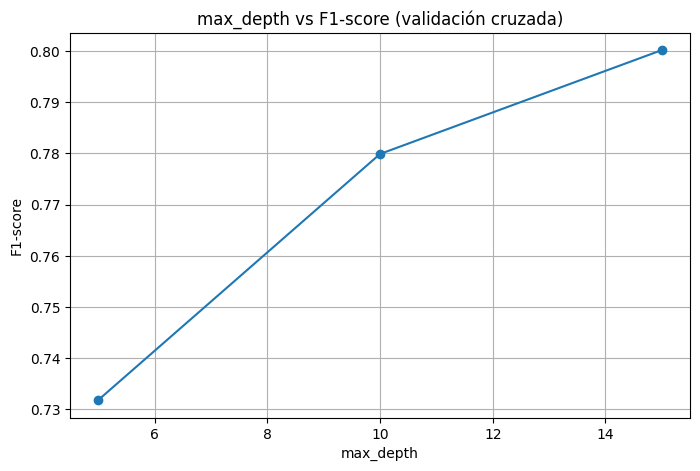

In [102]:
# 🌲 Árbol de decisión con búsqueda de hiperparámetros
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5, scoring='f1')
grid_tree.fit(X_train, y_train)
y_pred_tree = grid_tree.predict(X_test)

# Extraer resultados del GridSearchCV
results = pd.DataFrame(grid_tree.cv_results_)

# Filtrar para ver solo el impacto de max_depth (si querés, podés agregar más condiciones)
depth_vs_score = results.groupby('param_max_depth')['mean_test_score'].mean()

# Graficar niveles de max_depth vs F1-score
plt.figure(figsize=(8, 5))
plt.plot(depth_vs_score.index, depth_vs_score.values, marker='o')
plt.title("max_depth vs F1-score (validación cruzada)")
plt.xlabel("max_depth")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

In [103]:
# 🌳 RandomForest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [104]:
# ⚡ XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [67]:
# 🧠 Red neuronal
#agregar dropout y batch normalization
from keras.regularizers import l2
def create_nn_modelComplex(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'),l2(0.01))  # Regularización L2
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'),l2(0.01))  # Regularización L2
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'),l2(0.01))  # Regularización L2
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'),l2(0.01))  # Regularización L2
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'),l2(0.01))  # Regularización L2
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [68]:
nn_modelComplejo = create_nn_modelComplex(X_train.shape[1])

c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [112]:
nn_modelComplejo.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.3, verbose=1)

Epoch 1/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9505 - loss: 0.1276 - val_accuracy: 0.8113 - val_loss: 0.6272
Epoch 2/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9565 - loss: 0.1218 - val_accuracy: 0.8300 - val_loss: 0.5720
Epoch 3/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9539 - loss: 0.1180 - val_accuracy: 0.8376 - val_loss: 0.5627
Epoch 4/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9602 - loss: 0.1054 - val_accuracy: 0.8310 - val_loss: 0.6268
Epoch 5/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9600 - loss: 0.0977 - val_accuracy: 0.8151 - val_loss: 0.6741
Epoch 6/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9572 - loss: 0.1246 - val_accuracy: 0.8157 - val_loss: 0.6344
Epoch 7/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9585 - loss: 0.1018 - val_accuracy: 0.8118 - val_loss: 0.6682
Epoch 8/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9582 - loss: 0.1065 - 

In [55]:
# 🧠 Red neuronal
#agregar dropout y batch normalization
from keras.regularizers import l2
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))  # Dropout para evitar sobreajuste
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
# 🧠 Red neuronal
#usar el create model
input_dim = X_train.shape[1]
nn_model = create_nn_model(input_dim)
# Entrenar la red neuronal
nn_model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.35, verbose=1)
# Evaluación de modelos
# Usar el modelo entrenado para hacer predicciones



c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4933 - loss: 0.7637 - val_accuracy: 0.5508 - val_loss: 0.6926
Epoch 2/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5295 - loss: 0.6963 - val_accuracy: 0.5602 - val_loss: 0.6807
Epoch 3/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5445 - loss: 0.6912 - val_accuracy: 0.5677 - val_loss: 0.6803
Epoch 4/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5380 - loss: 0.6935 - val_accuracy: 0.5668 - val_loss: 0.6796
Epoch 5/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5535 - loss: 0.6882 - val_accuracy: 0.5381 - val_loss: 0.6861
Epoch 6/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5654 - loss: 0.6845 - val_accuracy: 0.5644 - val_loss: 0.6847
Epoch 7/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5502 - loss: 0.6833 - val_accuracy: 0.5541 - val_loss: 0.6835
Epoch 8/2000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5424 - loss: 0.6881 - 

In [141]:
nn_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.5, verbose=1,shuffle=True)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9955 - loss: 0.0174 - val_accuracy: 0.9404 - val_loss: 0.2779
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9935 - loss: 0.0232 - val_accuracy: 0.9223 - val_loss: 0.3510
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9893 - loss: 0.0262 - val_accuracy: 0.9266 - val_loss: 0.3373
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9915 - loss: 0.0251 - val_accuracy: 0.9351 - val_loss: 0.2935
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9920 - loss: 0.0219 - val_accuracy: 0.9427 - val_loss: 0.2875
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9927 - loss: 0.0240 - val_accuracy: 0.9457 - val_loss: 0.2611
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9949 - loss: 0.0180 - val_accuracy: 0.9427 - val_loss: 0.2786
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9918 - loss: 0.0243 - val_accuracy: 0.

In [ ]:

nn_modelComplejo = nn_modelComplejo.load('../modelos/redNeuronalCompleja.h5')


In [115]:
nn_modelComplejo.save('../modelos/redNeuronalCompleja.h5')

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision: 0.827
AUC ROC: 0.841


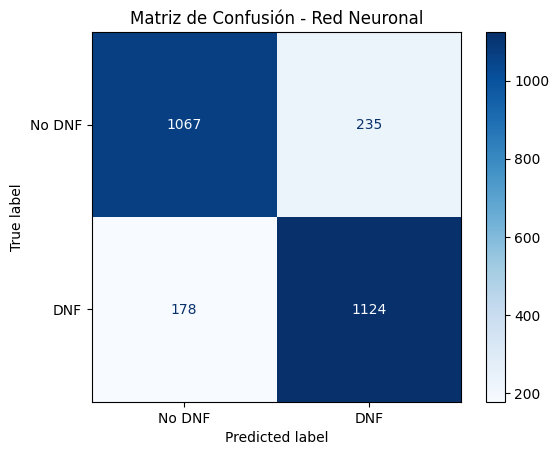

In [158]:
#evaluar red neuronal
from sklearn.metrics import precision_score


def evaluar_red_neuronal(red_neuronal):
    #evaluar la red neuronal
    y_pred_nn = red_neuronal.predict(X_test)
    y_pred_nn = (y_pred_nn > 0.8).astype(int)  # Convertir probabilidades a clases
    #calcular la precision
    precision = precision_score(y_test, y_pred_nn)
    #calcular auc roc
    fpr, tpr, _ = roc_curve(y_test, y_pred_nn)
    auc_roc = roc_auc_score(y_test, y_pred_nn)
    # Mostrar resultados
    print(f"Precision: {precision:.3f}")
    print(f"AUC ROC: {auc_roc:.3f}")
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred_nn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No DNF', 'DNF'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión - Red Neuronal")
    plt.show()
evaluar_red_neuronal(nn_modelComplejo)

In [159]:

def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre="Modelo"):
    #modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba")  else None

    if(nombre == "Red Neuronal"):
        y_proba = y_pred
        y_pred = (y_pred > 0.8).astype(int)  # Convertir probabilidades a clases

    print(f"🔍 Resultados para: {nombre}")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.3f}")
    else:
        auc = None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.show()
    
        

    return {
        "modelo": nombre,
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": auc
    }


🔍 Resultados para: ZeroR (Baseline)
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1302
           1       0.00      0.00      0.00      1302

    accuracy                           0.50      2604
   macro avg       0.25      0.50      0.33      2604
weighted avg       0.25      0.50      0.33      2604

ROC-AUC: 0.500


c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Users\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

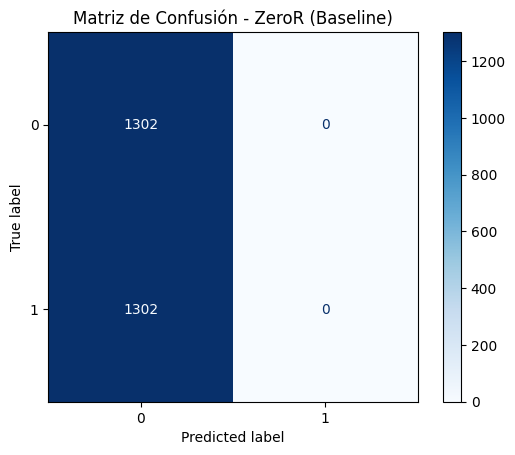

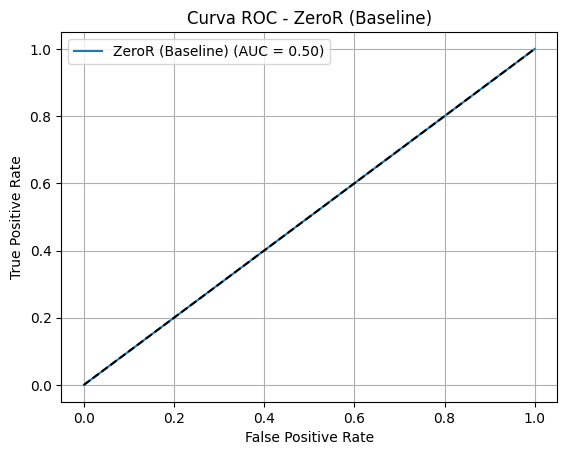

🔍 Resultados para: Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1302
           1       0.79      0.82      0.80      1302

    accuracy                           0.80      2604
   macro avg       0.80      0.80      0.80      2604
weighted avg       0.80      0.80      0.80      2604

ROC-AUC: 0.833


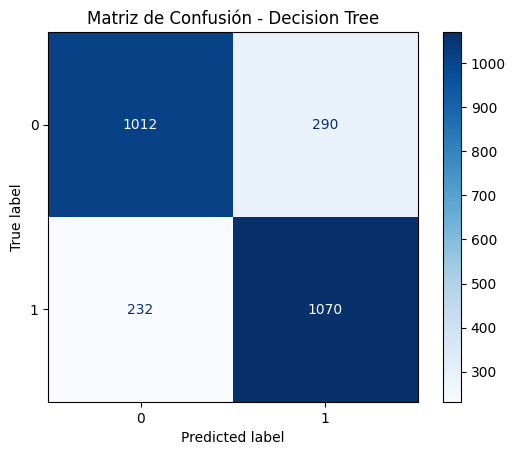

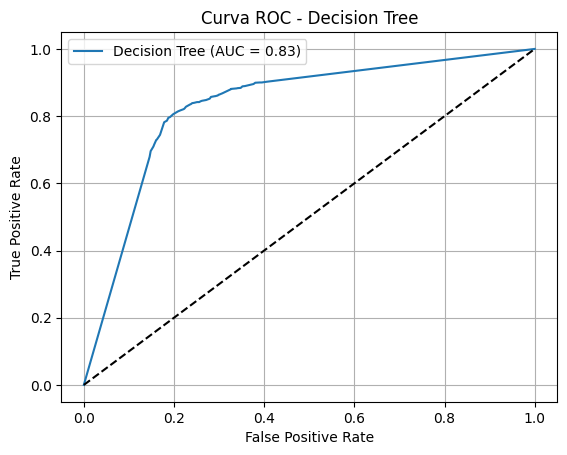

🔍 Resultados para: Random Forest
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1302
           1       0.92      0.88      0.90      1302

    accuracy                           0.90      2604
   macro avg       0.90      0.90      0.90      2604
weighted avg       0.90      0.90      0.90      2604

ROC-AUC: 0.961


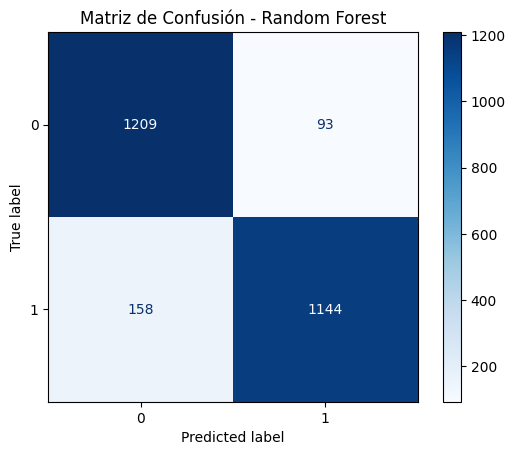

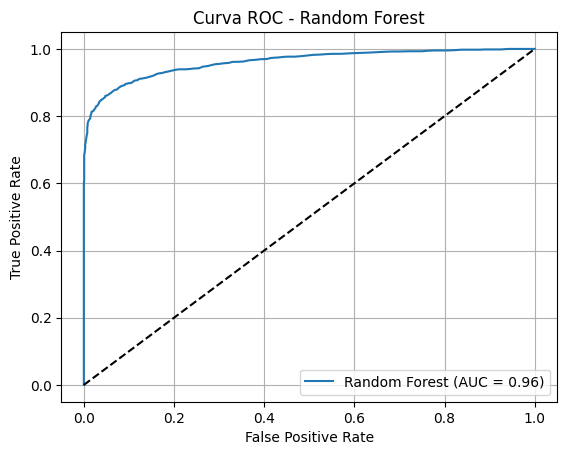

🔍 Resultados para: XGBoost
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1302
           1       0.93      0.85      0.89      1302

    accuracy                           0.89      2604
   macro avg       0.90      0.89      0.89      2604
weighted avg       0.90      0.89      0.89      2604

ROC-AUC: 0.940


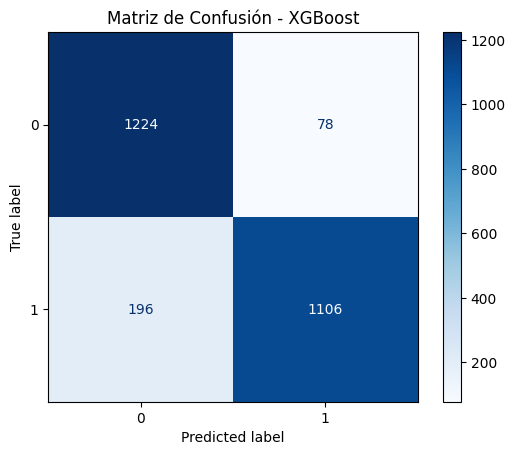

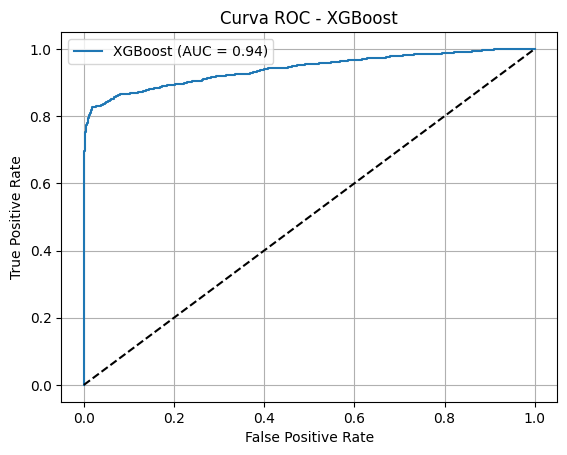

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔍 Resultados para: Red Neuronal
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1302
           1       0.83      0.86      0.84      1302

    accuracy                           0.84      2604
   macro avg       0.84      0.84      0.84      2604
weighted avg       0.84      0.84      0.84      2604

ROC-AUC: 0.910


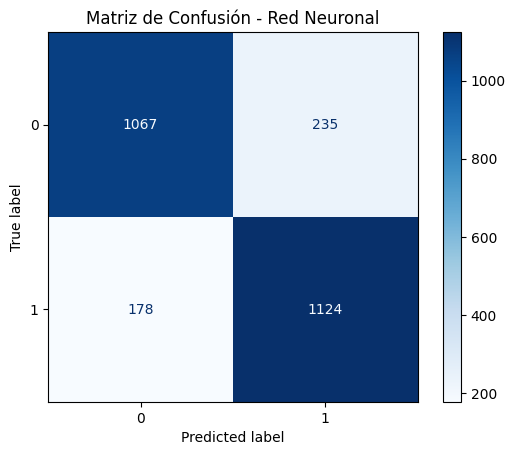

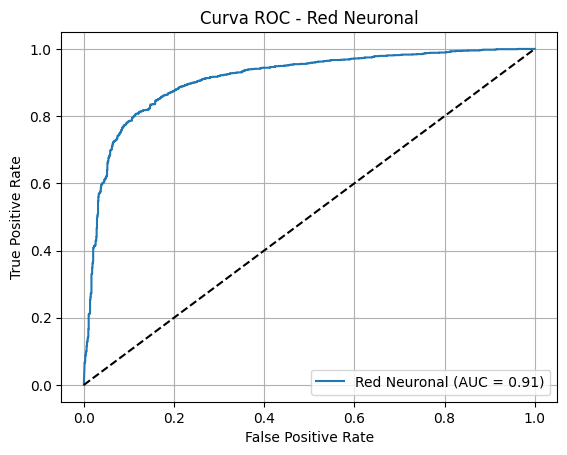

[{'modelo': 'ZeroR (Baseline)',
  'f1': 0.0,
  'accuracy': 0.5,
  'roc_auc': np.float64(0.5)},
 {'modelo': 'Decision Tree',
  'f1': 0.8039068369646882,
  'accuracy': 0.7995391705069125,
  'roc_auc': np.float64(0.8333371676801141)},
 {'modelo': 'Random Forest',
  'f1': 0.9011421819614022,
  'accuracy': 0.9036098310291859,
  'roc_auc': np.float64(0.9613500794004733)},
 {'modelo': 'XGBoost',
  'f1': 0.8897827835880934,
  'accuracy': 0.8947772657450077,
  'roc_auc': np.float64(0.9401865498193727)},
 {'modelo': 'Red Neuronal',
  'f1': 0.8447951897782788,
  'accuracy': 0.8413978494623656,
  'roc_auc': np.float64(0.9102131660850258)}]

In [162]:
resultados = []

resultados.append(evaluar_modelo(zeroR, X_train, X_test, y_train, y_test, "ZeroR (Baseline)"))

resultados.append(evaluar_modelo(grid_tree, X_train, X_test, y_train, y_test, "Decision Tree"))

resultados.append(evaluar_modelo(rf, X_train, X_test, y_train, y_test, "Random Forest"))

resultados.append(evaluar_modelo(xgb, X_train, X_test, y_train, y_test, "XGBoost"))

resultados.append(evaluar_modelo(nn_modelComplejo, X_train, X_test, y_train, y_test, "Red Neuronal"))
resultados

In [161]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Obtener las predicciones de la red neuronal en los datos de entrenamiento
probabilidades_train = nn_model.predict(X_train)
predicciones_train = (probabilidades_train > 0.5).astype(int)

# Calcular métricas de evaluación
resultados_nn_train = {
    "Exactitud": accuracy_score(y_train, predicciones_train),
    "F1-Score": f1_score(y_train, predicciones_train),
    "Recall": recall_score(y_train, predicciones_train),
    "Precisión": precision_score(y_train, predicciones_train)
}

# Mostrar el cuadro comparativo
print("Resultados de la Red Neuronal en los datos de entrenamiento:")
for metrica, valor in resultados_nn_train.items():
    print(f"{metrica}: {valor:.4f}")

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Resultados de la Red Neuronal en los datos de entrenamiento:
Exactitud: 0.9620
F1-Score: 0.9623
Recall: 0.9700
Precisión: 0.9546


C:\Users\Users\AppData\Local\Temp\ipykernel_2192\2938132115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="f1", data=pd.DataFrame(resultados), palette="viridis")


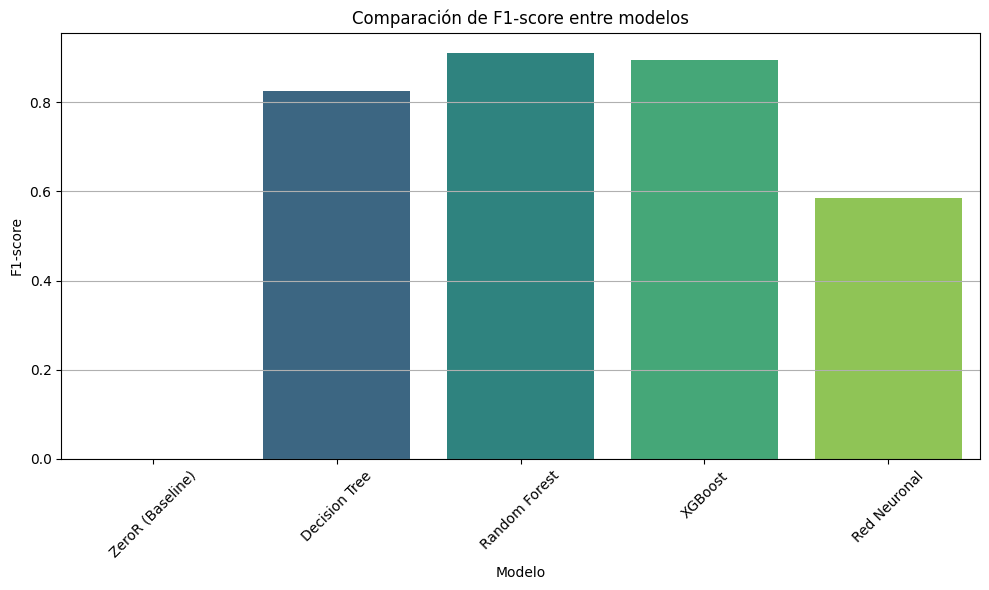

C:\Users\Users\AppData\Local\Temp\ipykernel_2192\2938132115.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="accuracy", data=pd.DataFrame(resultados), palette="viridis")


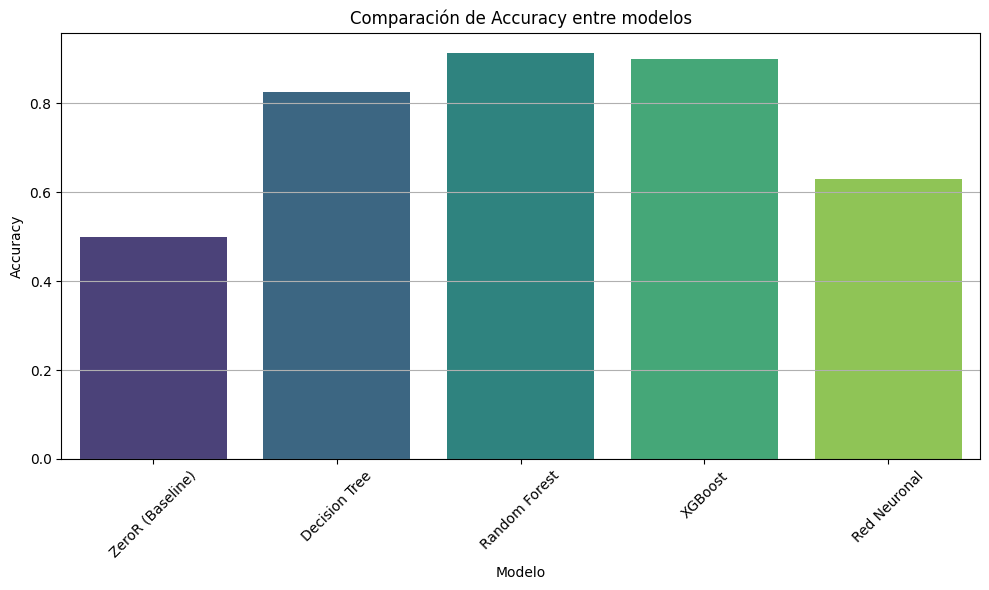

C:\Users\Users\AppData\Local\Temp\ipykernel_2192\2938132115.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="roc_auc", data=pd.DataFrame(resultados), palette="viridis")


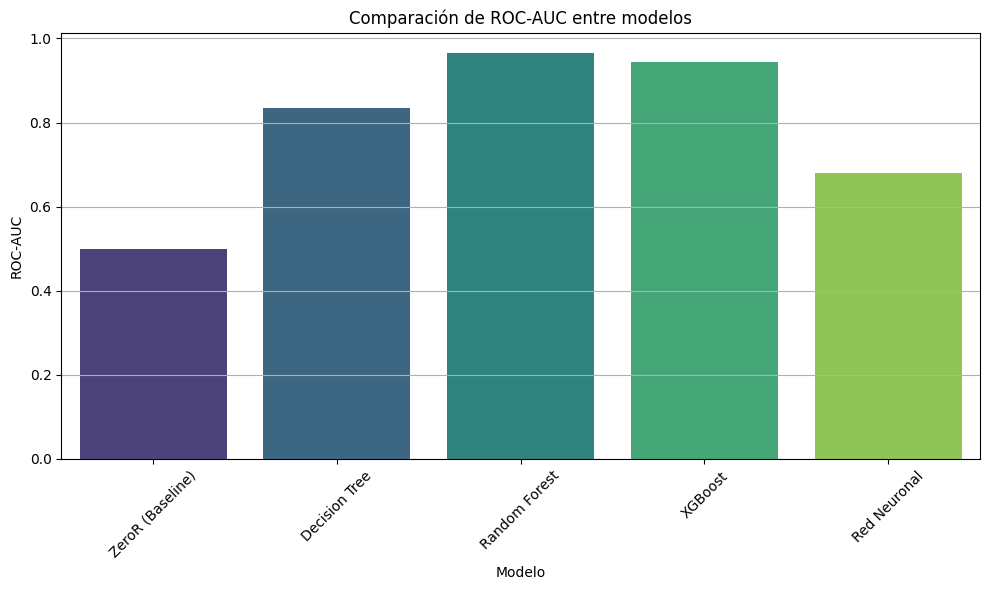

Ejemplo de columnas restantes: ['grid', 'avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position', 'races', 'wins', 'dnfs', 'win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races', 'circuit_prev_dnfs', 'circuit_prev_wins', 'circuit_prev_avg_pos', 'circuit_prev_avg_points', 'circuit_prev_dnf_rate', 'circuit_prev_win_rate', 'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change', 'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'driver_age', 'race_year', 'race_month', 'race_day', 'race_hour', 'DNF']


In [14]:
pd.DataFrame(resultados).set_index("modelo")
#graficar los resultados, de modo que se pueda ver la diferencia de f1, accuracy y roc_auc entre los mismos, tener en cuenta que es muy sutil (0.04 o 0.05) y que puede ser necesario hacer zoom en el eje y
plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="f1", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de F1-score entre modelos")
plt.ylabel("F1-score")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="accuracy", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="roc_auc", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de ROC-AUC entre modelos")
plt.ylabel("ROC-AUC")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Ejemplo de columnas restantes:", df.columns.tolist())

C:\Users\Users\AppData\Local\Temp\ipykernel_2192\3111352866.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_tree, palette='viridis')


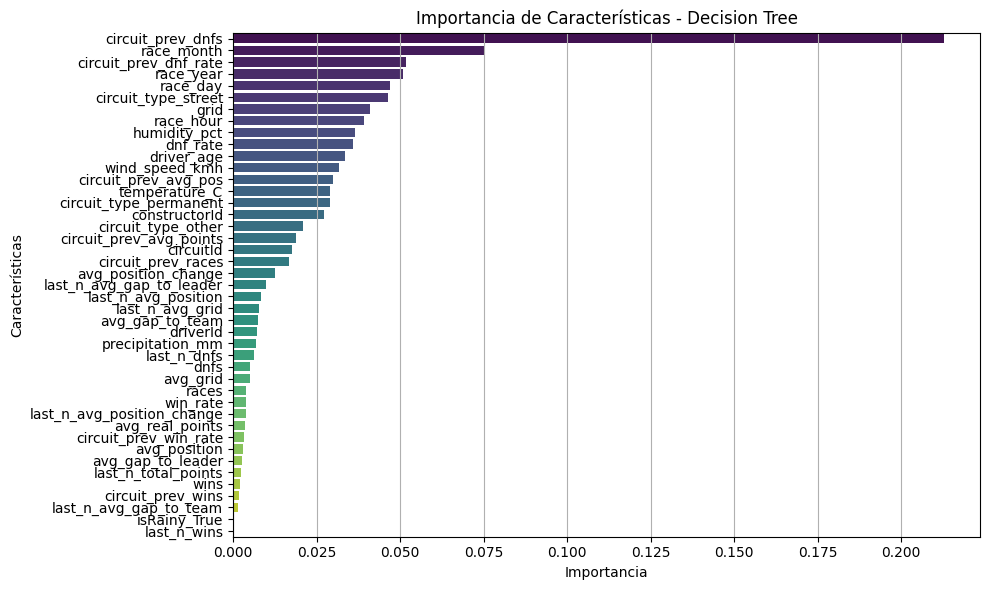

C:\Users\Users\AppData\Local\Temp\ipykernel_2192\3111352866.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_rf, palette='viridis')


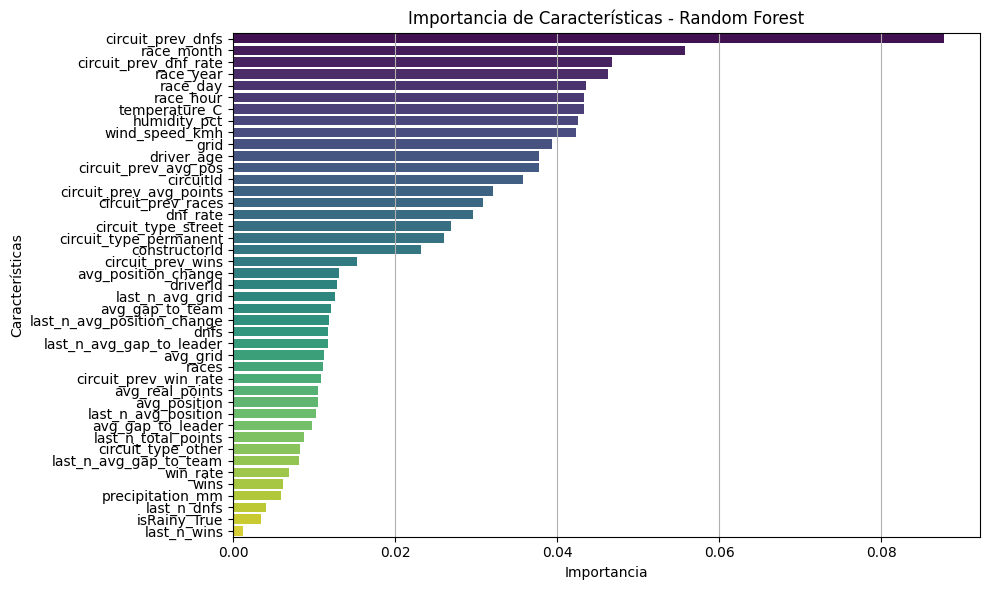

C:\Users\Users\AppData\Local\Temp\ipykernel_2192\3111352866.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_xgb, palette='viridis')


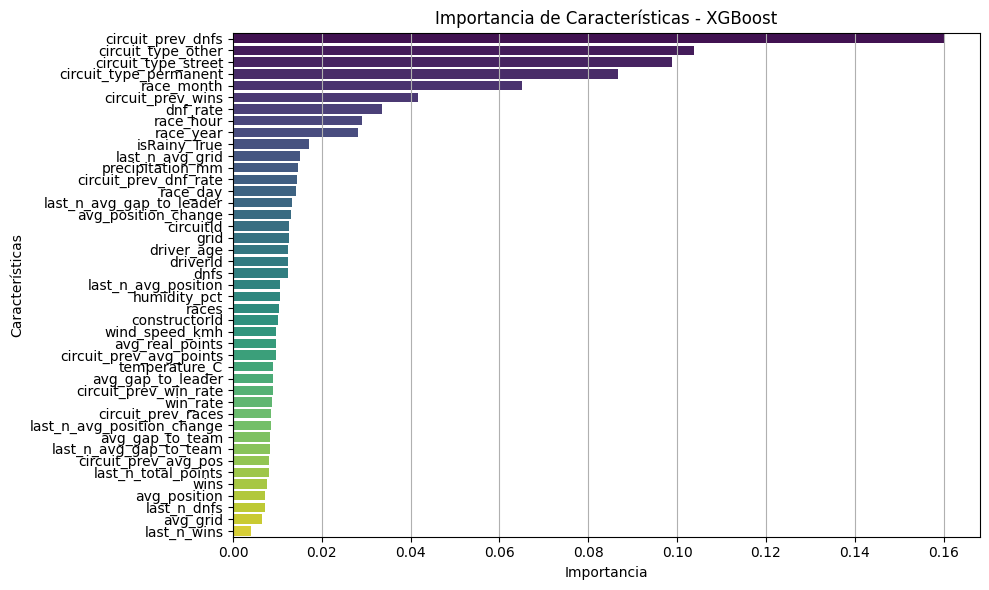

In [15]:
#variables mas importantes de cada modelo
# Importancia de características del decision tree
importances_tree = grid_tree.best_estimator_.feature_importances_
feature_names_tree = X_train.columns
importance_df_tree = pd.DataFrame({'feature': feature_names_tree, 'importance': importances_tree})
importance_df_tree = importance_df_tree.sort_values(by='importance', ascending=False)
# Graficar importancia de características del Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_tree, palette='viridis')
plt.title("Importancia de Características - Decision Tree")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
# Importancia de características del Random Forest
importances_rf = rf.feature_importances_
feature_names_rf = X_train.columns
importance_df_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='importance', ascending=False)
# Graficar importancia de características del Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_rf, palette='viridis')
plt.title("Importancia de Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
# Importancia de características del XGBoost
importances_xgb = xgb.feature_importances_
feature_names_xgb = X_train.columns
importance_df_xgb = pd.DataFrame({'feature': feature_names_xgb, 'importance': importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='importance', ascending=False)
# Graficar importancia de características del XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_xgb, palette='viridis')
plt.title("Importancia de Características - XGBoost")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [145]:
def predecir_dnf(modelo, df_original, filtro, features,nombre_modelo="Modelo"):
    # Filtramos las filas específicas
    df_filtrado = df_original.query(filtro).copy()

    if df_filtrado.empty:
        print("⚠️ No se encontraron filas con ese filtro.")
        return

    X_filtrado = df_filtrado[features]
    # Aplicar la misma codificación one-hot que en el entrenamiento
    X_filtrado_encoded = pd.get_dummies(X_filtrado, drop_first=True)
    # Alinear columnas con las usadas en el entrenamiento
    X_filtrado_encoded = X_filtrado_encoded.reindex(columns=X.columns, fill_value=0)

    predicciones = modelo.predict(X_filtrado_encoded)
    probabilidades = modelo.predict_proba(X_filtrado_encoded)[:, 1] if hasattr(modelo, "predict_proba") else None
    if nombre_modelo == "red neuronal":
        probabilidades = predicciones
        predicciones = (predicciones > 0.8).astype(int)
    # Mostramos resultados
    df_filtrado_resultado = df_filtrado.copy()
    df_filtrado_resultado['prediccion_DNF'] = predicciones
    ##if probabilidades is not None:
    df_filtrado_resultado['probabilidad_DNF'] = probabilidades

    return df_filtrado_resultado

🔎 Predicciones de DNF para: Decision Tree


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1744,84,2005,istanbul,ralf_schumacher,toyota,0,0,0.000000
1743,84,2005,istanbul,villeneuve,sauber,0,1,0.904762
1742,84,2005,istanbul,barrichello,ferrari,0,0,0.033333
1741,84,2005,istanbul,sato,bar,0,1,0.833333
1740,84,2005,istanbul,klien,red_bull,0,0,0.000000
1739,84,2005,istanbul,coulthard,red_bull,0,1,0.625000
1738,84,2005,istanbul,trulli,toyota,0,0,0.000000
1737,84,2005,istanbul,button,bar,0,0,0.000000
1752,84,2005,istanbul,webber,williams,1,1,0.965517
1751,84,2005,istanbul,massa,sauber,1,1,1.000000


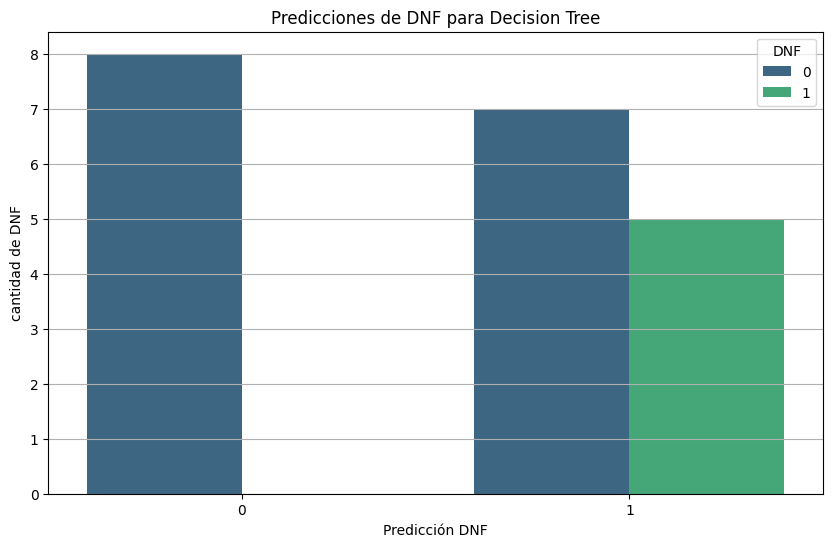

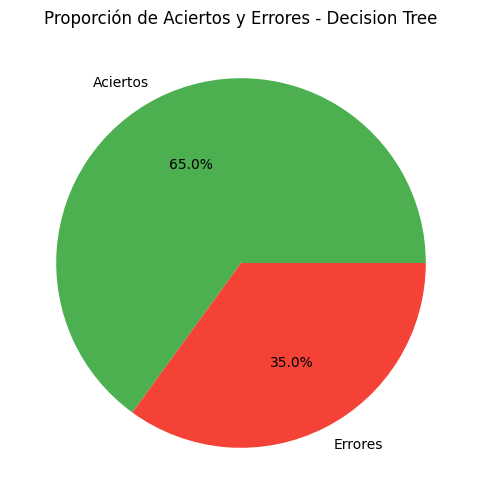

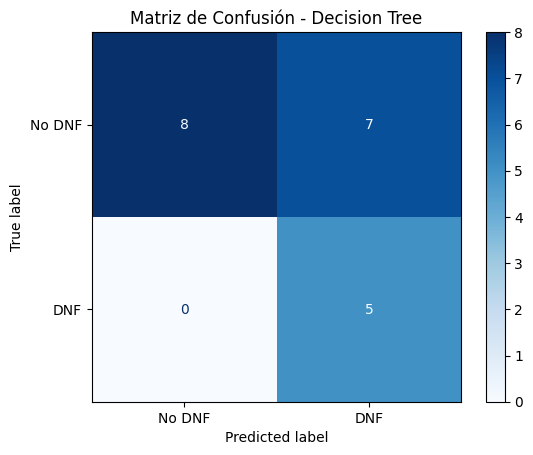

F1 Score para Decision Tree: 0.588
🔎 Predicciones de DNF para: Random Forest


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1744,84,2005,istanbul,ralf_schumacher,toyota,0,0,0.210
1743,84,2005,istanbul,villeneuve,sauber,0,0,0.490
1742,84,2005,istanbul,barrichello,ferrari,0,0,0.050
1741,84,2005,istanbul,sato,bar,0,1,0.510
1740,84,2005,istanbul,klien,red_bull,0,0,0.380
1739,84,2005,istanbul,coulthard,red_bull,0,0,0.110
1738,84,2005,istanbul,trulli,toyota,0,0,0.205
1737,84,2005,istanbul,button,bar,0,0,0.130
1752,84,2005,istanbul,webber,williams,1,1,0.605
1751,84,2005,istanbul,massa,sauber,1,1,0.820


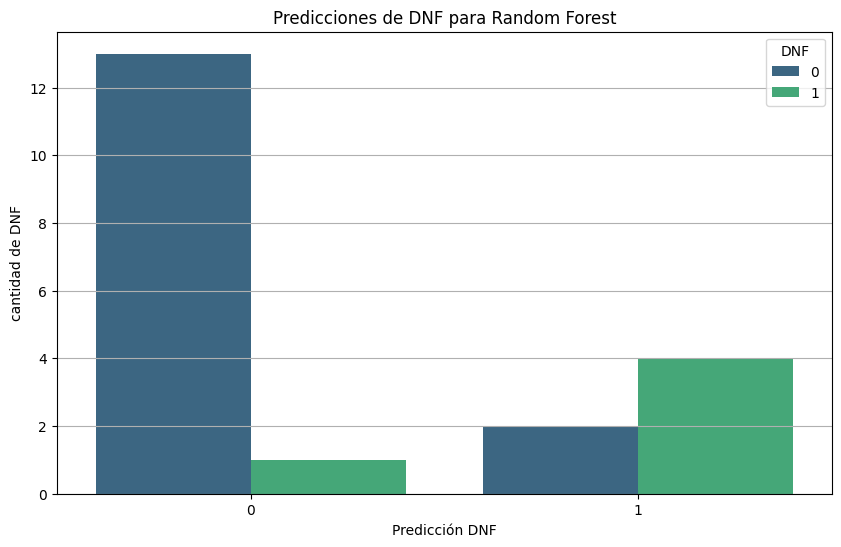

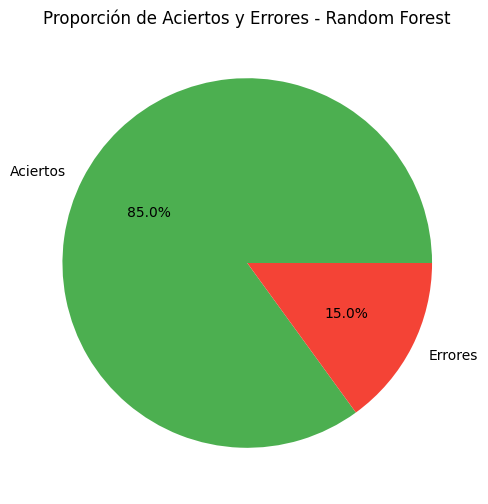

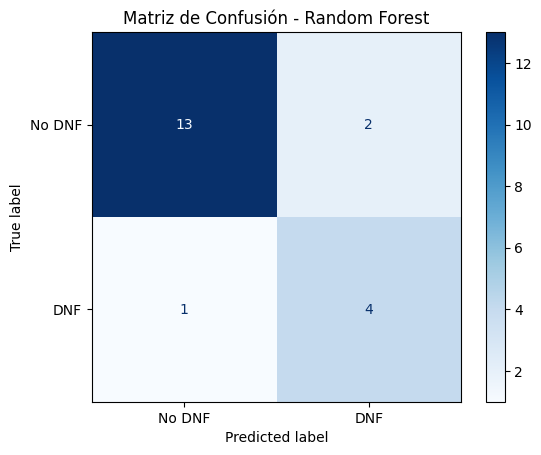

F1 Score para Random Forest: 0.727
🔎 Predicciones de DNF para: XGBoost


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1744,84,2005,istanbul,ralf_schumacher,toyota,0,0,0.154157
1743,84,2005,istanbul,villeneuve,sauber,0,0,0.042978
1742,84,2005,istanbul,barrichello,ferrari,0,0,0.050452
1741,84,2005,istanbul,sato,bar,0,0,0.144655
1740,84,2005,istanbul,klien,red_bull,0,0,0.264051
1739,84,2005,istanbul,coulthard,red_bull,0,0,0.153582
1738,84,2005,istanbul,trulli,toyota,0,0,0.124140
1737,84,2005,istanbul,button,bar,0,0,0.201375
1752,84,2005,istanbul,webber,williams,1,1,0.602010
1751,84,2005,istanbul,massa,sauber,1,1,0.769919


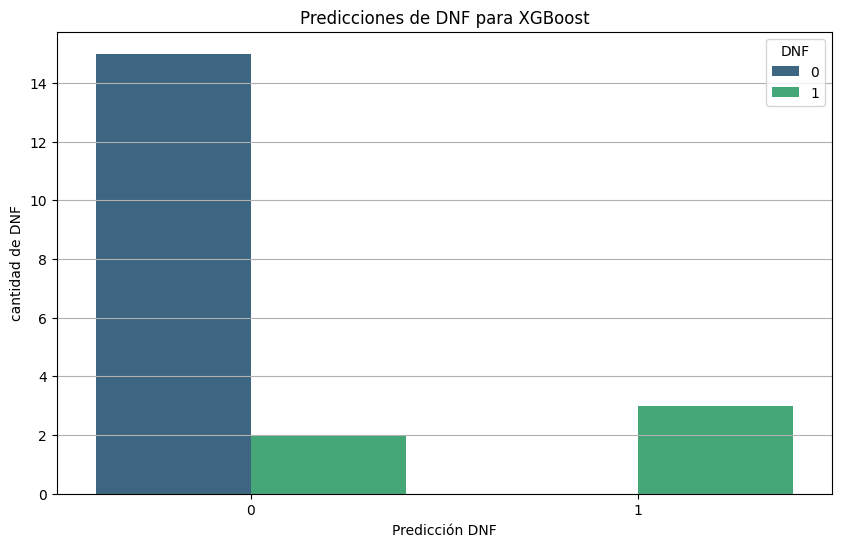

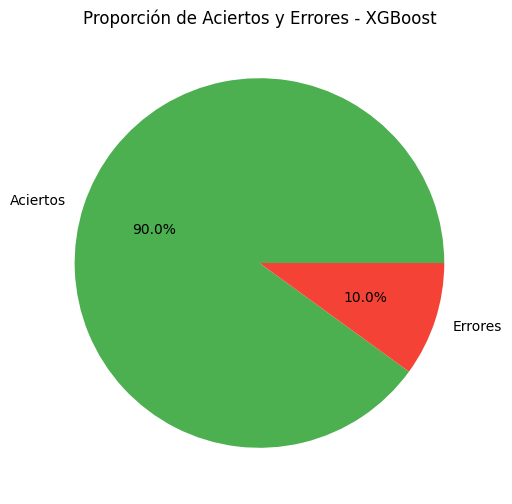

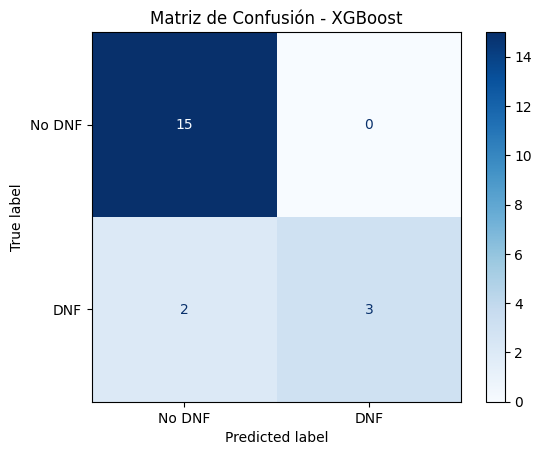

F1 Score para XGBoost: 0.750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔎 Predicciones de DNF para: Red Neuronal


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1744,84,2005,istanbul,ralf_schumacher,toyota,0,0,7.863117e-01
1743,84,2005,istanbul,villeneuve,sauber,0,0,9.475881e-21
1742,84,2005,istanbul,barrichello,ferrari,0,0,1.329236e-03
1741,84,2005,istanbul,sato,bar,0,0,9.475881e-21
1740,84,2005,istanbul,klien,red_bull,0,0,9.475881e-21
1739,84,2005,istanbul,coulthard,red_bull,0,0,1.519981e-02
1738,84,2005,istanbul,trulli,toyota,0,0,7.908886e-01
1737,84,2005,istanbul,button,bar,0,0,5.659083e-04
1752,84,2005,istanbul,webber,williams,1,1,9.988656e-01
1751,84,2005,istanbul,massa,sauber,1,1,9.999979e-01


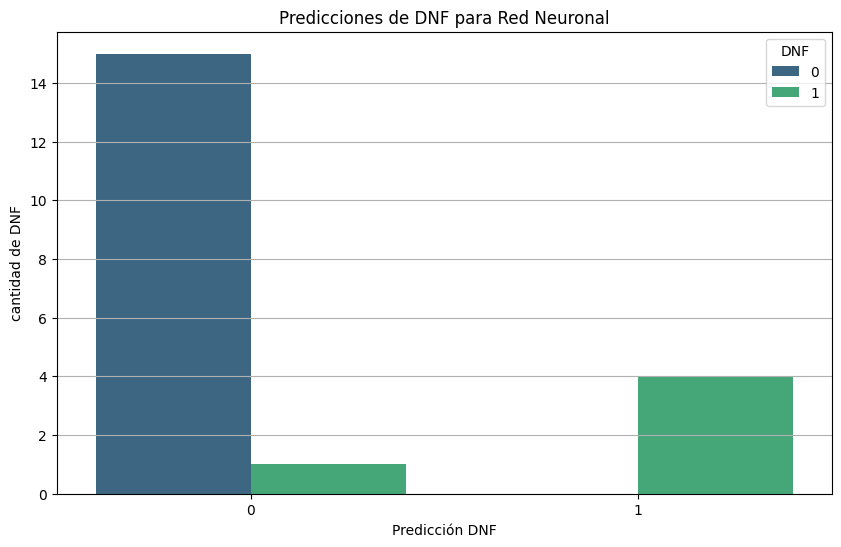

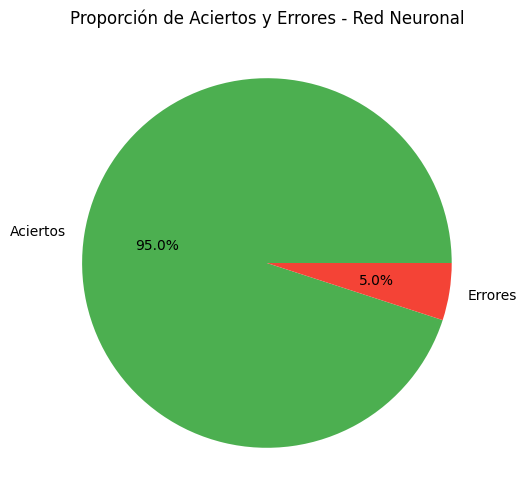

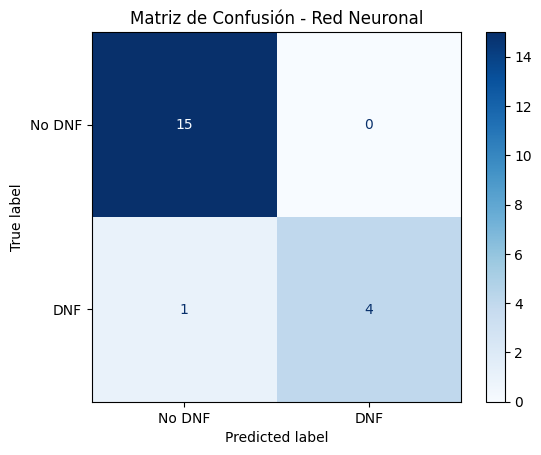

F1 Score para Red Neuronal: 0.889


In [154]:
filtro = "raceId == 84"

# Para el árbol de decisión
df_decision_tree = predecir_dnf(grid_tree.best_estimator_, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: Decision Tree")
display(df_decision_tree[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_decision_tree['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para Decision Tree
plt.figure(figsize=(10, 6))
sns.countplot(data=df_decision_tree, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para Decision Tree")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()
# Calcular proporciones
aciertos = (df_decision_tree['DNF'] == df_decision_tree['prediccion_DNF']).sum()
errores = (df_decision_tree['DNF'] != df_decision_tree['prediccion_DNF']).sum()

# Crear gráfico de tarta
plt.figure(figsize=(6, 6))
plt.pie([aciertos, errores], labels=['Aciertos', 'Errores'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("Proporción de Aciertos y Errores - Decision Tree")
plt.show()

# Crear matriz de confusión para el modelo
cm = confusion_matrix(df_decision_tree['DNF'], df_decision_tree['prediccion_DNF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No DNF', 'DNF'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Decision Tree")
plt.show()

#f1score
f1_score_decision_tree = f1_score(df_decision_tree['DNF'], df_decision_tree['prediccion_DNF'])
print(f"F1 Score para Decision Tree: {f1_score_decision_tree:.3f}")

# Para probar con el modelo de Random Forest
df_random_forest = predecir_dnf(rf, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: Random Forest")
display(df_random_forest[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_random_forest['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para random forest
plt.figure(figsize=(10, 6))
sns.countplot(data=df_random_forest, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para Random Forest")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()


# Calcular proporciones
aciertos = (df_random_forest['DNF'] == df_random_forest['prediccion_DNF']).sum()
errores = (df_random_forest['DNF'] != df_random_forest['prediccion_DNF']).sum()
# Crear gráfico de tarta
plt.figure(figsize=(6, 6))
plt.pie([aciertos, errores], labels=['Aciertos', 'Errores'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("Proporción de Aciertos y Errores - Random Forest")
plt.show()
# Crear matriz de confusión para el modelo
cm = confusion_matrix(df_random_forest['DNF'], df_random_forest['prediccion_DNF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No DNF', 'DNF'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

#f1score
f1_score_random_forest = f1_score(df_random_forest['DNF'], df_random_forest['prediccion_DNF'])
print(f"F1 Score para Random Forest: {f1_score_random_forest:.3f}")

# Para XGBoost
df_xgboost = predecir_dnf(xgb, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: XGBoost")
display(df_xgboost[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_xgboost['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para xgboost
plt.figure(figsize=(10, 6))
sns.countplot(data=df_xgboost, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para XGBoost")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()
# Calcular proporciones
aciertos = (df_xgboost['DNF'] == df_xgboost['prediccion_DNF']).sum()
errores = (df_xgboost['DNF'] != df_xgboost['prediccion_DNF']).sum() 
# Crear gráfico de tarta
plt.figure(figsize=(6, 6))
plt.pie([aciertos, errores], labels=['Aciertos', 'Errores'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("Proporción de Aciertos y Errores - XGBoost")
plt.show()
# Crear matriz de confusión para el modelo
cm = confusion_matrix(df_xgboost['DNF'], df_xgboost['prediccion_DNF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No DNF', 'DNF'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - XGBoost")
plt.show()
#f1score
f1_score_xgboost = f1_score(df_xgboost['DNF'], df_xgboost['prediccion_DNF'])
print(f"F1 Score para XGBoost: {f1_score_xgboost:.3f}")


# Para la red neuronal
df_neural_network = predecir_dnf(nn_model, df_original, filtro, features,"red neuronal")
print(f"🔎 Predicciones de DNF para: Red Neuronal")
display(df_neural_network[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_neural_network['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para red neuronal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_neural_network, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para Red Neuronal")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()
# Calcular proporciones
aciertos = (df_neural_network['DNF'] == df_neural_network['prediccion_DNF']).sum()
errores = (df_neural_network['DNF'] != df_neural_network['prediccion_DNF']).sum()
# Crear gráfico de tarta    
plt.figure(figsize=(6, 6))
plt.pie([aciertos, errores], labels=['Aciertos', 'Errores'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("Proporción de Aciertos y Errores - Red Neuronal")
plt.show()
# Crear matriz de confusión para el modelo
cm = confusion_matrix(df_neural_network['DNF'], df_neural_network['prediccion_DNF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No DNF', 'DNF'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Red Neuronal")
plt.show()
#f1score
f1_score_neural_network = f1_score(df_neural_network['DNF'], df_neural_network['prediccion_DNF'])
print(f"F1 Score para Red Neuronal: {f1_score_neural_network:.3f}")